In [1]:
import sys
print("Python executable:", sys.executable)

# Use quotes so Windows treats the path as one
!"{sys.executable}" -m pip install scikit-learn statsmodels matplotlib pandas


Python executable: C:\Users\Love\Desktop\EDA analysis\venv\Scripts\python.exe


In [2]:
# Cell 1 - Import libraries 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Cell 2 - Load data and inspect
fp =  r'C:\Users\Love\Desktop\EDA analysis\EDA_Analysis_2\cleaned_stock_prices.csv'
df = pd.read_csv(fp)
print("Shape:", df.shape)
print(df.columns.tolist())
display(df.head())

Shape: (497472, 7)
['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']


,symbol,date,open,high,low,close,volume
0,aal,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,aapl,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,aap,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,abbv,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,abc,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


In [4]:
# Cell 3 - Convert date & basic cleaning
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

df = df.dropna(subset=['symbol', 'date', 'close'])
print("After cleaning  shape:", df.shape)

After cleaning  shape: (497472, 7)


In [5]:
# Cell 4 - Aggregate per symbol maeans I need to extract the per-symbol statistical metrics
df = df.sort_values(['symbol', 'date'])
df['return'] = df.groupby('symbol')['close'].pct_change()

agg = df.groupby('symbol').agg(
    mean_close=('close', 'mean'),
    std_close=('close', 'std'),
    mean_volume=('volume', 'mean'),
    std_volume=('volume', 'std'),
    mean_return=('return', 'mean'),
    std_return=('return', 'std'),
    mean_open=('open', 'mean'),
    mean_high=('high', 'mean'),
    mean_low=('low', 'mean')
). fillna(0)

print("Aggregated per-symbol shape:", agg.shape)
display(agg.head())

Aggregated per-symbol shape: (505, 9)


,mean_close,std_close,mean_volume,std_volume,mean_return,std_return,mean_open,mean_high,mean_low
symbol,,,,,,,,,
a,49.097726,9.375208,2.191932e+06,1.191060e+06,0.000306,0.015787,49.085571,49.485352,48.680860
aal,42.424900,6.063245,9.751521e+06,6.729854e+06,0.000965,0.022389,42.420103,43.037743,41.799285
aap,143.187120,24.610670,1.137307e+06,1.090246e+06,0.000096,0.019471,143.205079,144.716834,141.663015
aapl,116.839892,24.547273,4.516957e+07,2.490233e+07,0.000860,0.014309,116.811396,117.747015,115.856082
abbv,63.338302,10.497342,8.408836e+06,6.141101e+06,0.000753,0.016436,63.296754,63.960244,62.651796


In [6]:
# Cell 5 - Feature cleaning & selection
to_drop = [c for c in agg.columns if agg[c].std()==0]
if to_drop:
    print("Dropping zero-variance columns:", to_drop)
    agg = agg.drop(columns=to_drop)
display(agg.describe().T)

,count,mean,std,min,25%,50%,75%,max
mean_close,505.0,8.582327e+01,9.696299e+01,5.908605,4.385070e+01,6.654532e+01,9.881711e+01,1.390273e+03
std_close,505.0,1.593712e+01,2.279268e+01,1.194734,6.550787e+00,1.045293e+01,1.754878e+01,2.640389e+02
mean_volume,505.0,4.242756e+06,6.679430e+06,171919.862959,1.331588e+06,2.282951e+06,4.304877e+06,8.936290e+07
std_volume,505.0,2.579784e+06,3.953593e+06,166908.800091,8.468097e+05,1.417292e+06,2.616511e+06,4.105188e+07
mean_return,505.0,4.417758e-04,5.279557e-04,-0.003969,1.973320e-04,4.766231e-04,7.082867e-04,2.760199e-03
std_return,505.0,1.558932e-02,5.028020e-03,0.008284,1.220678e-02,1.439118e-02,1.759715e-02,4.551547e-02
mean_open,505.0,8.580769e+01,9.696144e+01,5.911949,4.384003e+01,6.651012e+01,9.878688e+01,1.390184e+03
mean_high,505.0,8.658322e+01,9.780235e+01,6.033305,4.423143e+01,6.702681e+01,9.956223e+01,1.402186e+03
mean_low,505.0,8.501151e+01,9.606450e+01,5.785591,4.346680e+01,6.599576e+01,9.803561e+01,1.377425e+03


In [7]:
# Cell 6 -  Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(agg.values)
print("Scaled feature shape:", X.shape)

Scaled feature shape: (505, 9)


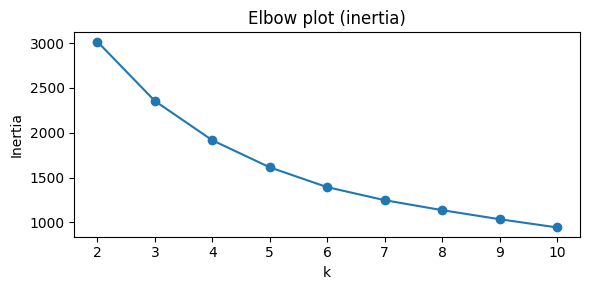

In [15]:
# Cell 7 - Elbow method
inertias = []
K = range(2,11)
for k in K:
    km =  KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,3))
plt.plot(range(2,11), inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow plot (inertia)')
plt.tight_layout()
plt.savefig('elbow_inertia.png')
plt.show()

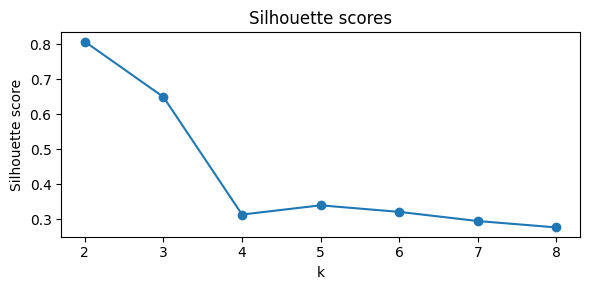

Silhouette values: [(2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (8, 5)]


In [28]:
# Cell 8 -  Silhouette score this is for extra check I use silhouette and elbow together  to decide k
from sklearn.metrics import silhouette_score
sil_scores = []
ks = range(2,9)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=5).fit(X)
    labels = km.labels_
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
plt.figure(figsize=(6,3))
plt.plot(list(ks), sil_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores')
plt.tight_layout()
plt.savefig('silhouette_scores.png')
plt.show()
print("Silhouette values:", list(zip(ks, [round(5,4) for s in sil_scores])))

In [18]:
# Cell 9 - Final KMeans fit and view cluster sizes
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X)
agg['cluster'] = kmeans.labels_
print(agg['cluster'].value_counts())
display(agg.head())

agg.to_csv('per_symbol_clusters.csv', index=True)
print("Saved files: per_symbol_clusters.csv")

cluster
0    479
2     18
1      8
Name: count, dtype: int64


,mean_close,std_close,mean_volume,std_volume,mean_return,std_return,mean_open,mean_high,mean_low,cluster
symbol,,,,,,,,,,
a,49.097726,9.375208,2.191932e+06,1.191060e+06,0.000306,0.015787,49.085571,49.485352,48.680860,0
aal,42.424900,6.063245,9.751521e+06,6.729854e+06,0.000965,0.022389,42.420103,43.037743,41.799285,0
aap,143.187120,24.610670,1.137307e+06,1.090246e+06,0.000096,0.019471,143.205079,144.716834,141.663015,0
aapl,116.839892,24.547273,4.516957e+07,2.490233e+07,0.000860,0.014309,116.811396,117.747015,115.856082,2
abbv,63.338302,10.497342,8.408836e+06,6.141101e+06,0.000753,0.016436,63.296754,63.960244,62.651796,0


Saved files: per_symbol_clusters.csv


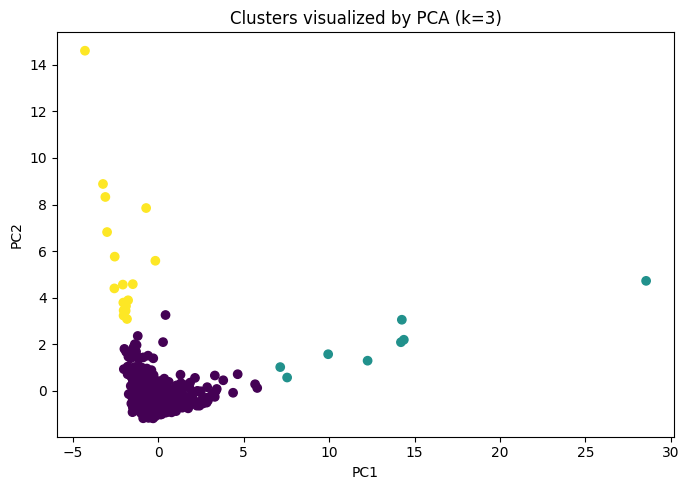

In [20]:
# Cell 10 - Visualizing clusters in 2D using
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=agg['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Clusters visualized by PCA (k={k})')
plt.tight_layout()
plt.savefig('clusters_pca.png')
plt.show()

In [22]:
# Cell 10 - Now I Inspect cluster centers to understand groups
centroids = kmeans.cluster_centers_
centroids_unscaled = scaler.inverse_transform(centroids)
cent_df = pd.DataFrame(centroids_unscaled, columns=agg.columns[:-1])
display(cent_df)

,mean_close,std_close,mean_volume,std_volume,mean_return,std_return,mean_open,mean_high,mean_low
0,77.803634,13.853717,3.284039e+06,1.981052e+06,0.000441,0.015414,77.786995,78.491618,77.068734
1,676.732378,157.601953,1.337983e+06,7.983773e+05,0.000620,0.016434,676.744867,682.772627,670.277791
2,36.608528,8.416669,3.104628e+07,1.930446e+07,0.000378,0.019881,36.608455,36.936713,36.259336


In [29]:
# Cell 11 - Saving plots and results
import os 
print("Files you should have in notebook folder:")
for f in ['elbow_inertia.png', 'silhouette_scores.png', 'clusters_pca.png', 'per_symbol_clusters.csv']:
    print(" -", f, "exists?", os.path.exists(f))

Files you should have in notebook folder:
 - elbow_inertia.png exists? True
 - silhouette_scores.png exists? True
 - clusters_pca.png exists? True
 - per_symbol_clusters.csv exists? True
